# Import libraries and read train csv file

In [1]:
!pip install transformers
!pip install adjustText
!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 44.8 MB/s 
     |████████████████████████████████| 596 kB 40.9 MB/s 
     |████████████████████████████████| 86 kB 4.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7097 sha256=9df9af025063d47b024cb6664f5c23cc77f94c9d5a335dc836db2bab79d89639
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built adjustText
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |█████████████████████████

In [2]:
import pandas as pd
import numpy as np
import re

from collections import Counter

import spacy

import gensim
from gensim.models import Word2Vec

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset, DataLoader


from adjustText import adjust_text
import matplotlib.pyplot as plt

import transformers
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Classes are balanced -> we will use the "Accuracy" metric

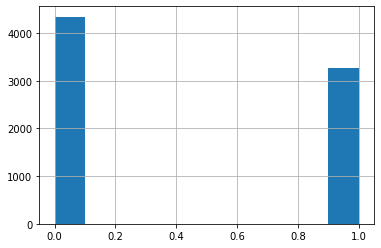

In [4]:
df_train['target'].hist();

### Function for cleaning text from URLs, numbers and symbols.
### Remove stop words and perform lematization using the "spacy" library 

In [5]:
nlp = spacy.load('en_core_web_sm')

In [6]:
def re_func(review):
    review = re.sub(r'http\S+', '', review)
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower()
    review = review.split()

    review = ' '.join([word for word in review if word not in nlp.Defaults.stop_words and len(word) > 2])
    doc = nlp(review)
    text = []
    for token in doc:
        text.append(token.lemma_)
    return text

In [7]:
def list_to_str(list_of_words):
    return ' '.join(list_of_words)

In [8]:
df_train['new_text'] = df_train['text'].apply(re_func)
df_test['new_text'] = df_test['text'].apply(re_func)

CPU times: user 1min 39s, sys: 362 ms, total: 1min 40s
Wall time: 1min 42s


### The most popular words in all tweets

In [9]:
full_text = []
df_train['new_text'].apply(lambda x: full_text.append(x))

word_counter = Counter([word for sentence in full_text for word in sentence])

list_of_pop_words = []

word_counter.most_common(30)

[('like', 395),
 ('fire', 358),
 ('amp', 344),
 ('new', 234),
 ('go', 226),
 ('get', 213),
 ('news', 213),
 ('people', 201),
 ('don', 192),
 ('kill', 175),
 ('burn', 174),
 ('video', 174),
 ('bomb', 167),
 ('crash', 164),
 ('disaster', 162),
 ('emergency', 159),
 ('come', 158),
 ('time', 156),
 ('year', 155),
 ('body', 155),
 ('attack', 155),
 ('day', 150),
 ('man', 147),
 ('look', 143),
 ('police', 143),
 ('home', 142),
 ('know', 136),
 ('family', 130),
 ('storm', 129),
 ('building', 128)]

## Word2Vec

In [16]:
model = Word2Vec(min_count=20, window=3)
model.build_vocab(df_train['new_text'])
model.train(df_train['new_text'], total_examples=len(df_train['new_text']), epochs=20)

(587036, 1257580)

### Vector of word "fire"

In [17]:
model.wv.get_vector('fire')[:20]

array([ 0.11932087,  0.5226273 ,  0.08518273,  0.15649064,  0.5728483 ,
       -0.53488797,  0.46776745,  0.4569301 , -0.4489738 , -0.5608541 ,
       -0.6477858 , -0.7957941 , -0.6871414 , -0.06162398, -0.31981868,
       -0.5802921 ,  0.44216225,  0.19420914,  0.03758707, -0.35750723],
      dtype=float32)

In [18]:
words = list(model.wv.key_to_index.keys())

### Decrease the dimensionality by TSNE()

In [19]:
X = model.wv.vectors
X_embed = TSNE(n_iter=500).fit_transform(X)

### In two-dimensional space, you can see the proximity of words.
### For example, the words "nuclear," "weapon," "war," and "hiroshima" are close together.

53

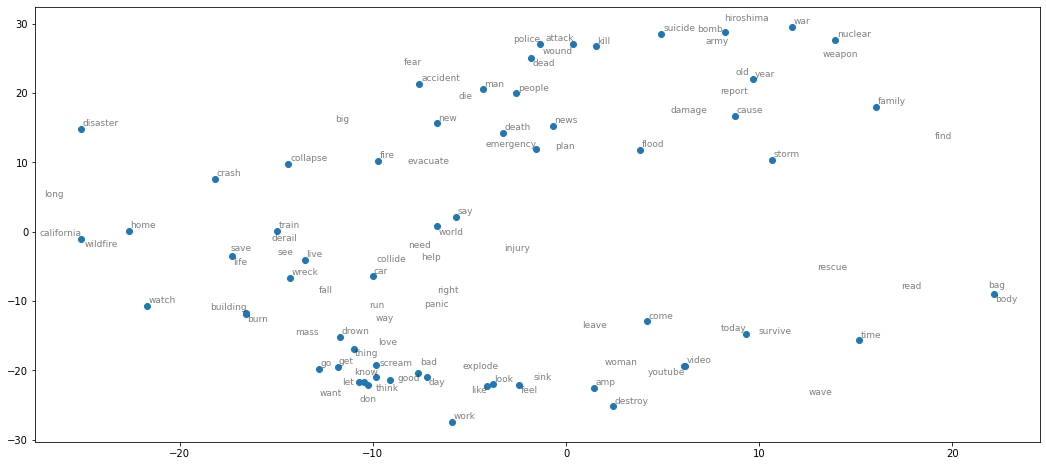

In [20]:
plt.figure(figsize=(18, 8))
plt.scatter(X_embed[:60, 0], X_embed[:60, 1])
annotations = []
for i, word in enumerate(words[:100]):
    annotations.append(plt.annotate(word, xy=(X_embed[i, 0]+.05, X_embed[i, 1]), fontsize=9, alpha=.5, ))
adjust_text(annotations)

### Words similar by vectors

In [21]:
model.wv.most_similar('nuclear', topn=20)

[('fukushima', 0.8839332461357117),
 ('reactor', 0.8677733540534973),
 ('japan', 0.822580099105835),
 ('weapon', 0.7969130873680115),
 ('power', 0.7703032493591309),
 ('deal', 0.7501725554466248),
 ('government', 0.7354268431663513),
 ('hiroshima', 0.7190524935722351),
 ('atomic', 0.7090678215026855),
 ('anniversary', 0.6989818811416626),
 ('america', 0.6873546838760376),
 ('years', 0.6848206520080566),
 ('natural', 0.6806631684303284),
 ('disaster', 0.6742790341377258),
 ('catastrophic', 0.6649702787399292),
 ('war', 0.6434372067451477),
 ('devastation', 0.6402702331542969),
 ('bioterrorism', 0.6341562867164612),
 ('iran', 0.6335960626602173),
 ('country', 0.6329742670059204)]

# BERT model

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


### Define model, tokenizer and weights

In [23]:
model_class = transformers.DistilBertModel

tokenizer_class = transformers.DistilBertTokenizer

pretrained_weights = 'distilbert-base-uncased'

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Set the maximum length of the sequence.

### Apply tokenizer: 
- add_special_tokens = add service tokens
- truncation = trim to maximum length
- max_length = maximum length of the sequence

### To complete the sequences to a fixed length, add zeros to the short sequences 

In [24]:
max_len = 32
tokenized = df_train['new_text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, 
                                                                      truncation=True, 
                                                                      max_length=max_len)))
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

### Denote where we added the mask, so that the model does not consider this area when processing

In [25]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask[0]

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [26]:
print(padded[0])
print(attention_mask[0])

[  101 15616  3114  8372 16455  9641   102     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Get the model output (we don't need everything from there)

In [27]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.inference_mode():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

CPU times: user 5min 55s, sys: 39.4 s, total: 6min 35s
Wall time: 6min 39s


In [28]:
model_out_shape = last_hidden_states[0].shape
print(f'{model_out_shape[0]} - number of objects,\n \
{model_out_shape[1]} - the length of each sequence, \n \
{model_out_shape[2]} - the length of the BERT output vector')

7613 - number of objects,
 32 - the length of each sequence, 
 768 - the length of the BERT output vector


### Take only output vectors for each object

In [29]:
features = last_hidden_states[0][:,0,:].numpy()

In [30]:
train_features, test_features, train_labels, test_labels = train_test_split(features, df_train['target'])

In [31]:
gbc_model = GradientBoostingClassifier(learning_rate=0.001)
gbc_model.fit(train_features, train_labels)

CPU times: user 2min 42s, sys: 136 ms, total: 2min 42s
Wall time: 2min 48s


In [32]:
gbc_model.score(test_features, test_labels)

0.5577731092436975

# PyTorch FC model

### Tokenization and vocabulary creation

In [33]:
tokenizer = get_tokenizer('basic_english')
def yield_tokens(data):
    for text in data:
        for word in text:
            yield tokenizer(word)

vocab = build_vocab_from_iterator(yield_tokens(df_train['new_text']), specials=['<unk>'], min_freq=2)
vocab.set_default_index(vocab['<unk>'])

### Translating text into tokens

In [34]:
vocab(['earthquake', 'fire', 'nuclear'])

[185, 2, 49]

In [35]:
len(vocab)

5217

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Custom dataset class

In [37]:
class TextDataset(Dataset):

    def __init__(self, text, labels, vocab_size):

        self.text = text.tolist()
        self.labels = labels.tolist()
        self.vocab_size = vocab_size

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        self.one_hot = torch.zeros(self.vocab_size)
        self.one_hot[vocab(self.text[idx])] = 1.0

        self.label = torch.zeros(2)
        self.label[self.labels[idx]] = 1.0

        return self.one_hot, self.label

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df_train['new_text'], df_train['target'], train_size=0.8)

train_data = TextDataset(X_train, y_train, vocab_size=len(vocab))
test_data = TextDataset(X_test, y_test, vocab_size=len(vocab))

In [39]:
train_dl = DataLoader(dataset = train_data, batch_size=1000, shuffle=True)
test_dl = DataLoader(dataset=test_data, batch_size=1000)

### Fully connected network class
2 layers:
- input = vocabulary size, output = 5000
- input = 5000, output = 2

Adding Dropout and other layers does not improve the model

In [40]:
class ANNmodel(nn.Module):

    def __init__(self, vocab_size, out_size=2):

        super().__init__()

        self.fc1 = nn.Linear(vocab_size, 5000)
        self.fc2 = nn.Linear(5000, out_size)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = self.fc2(X)

        return torch.sigmoid(X)

In [41]:
model = ANNmodel(len(vocab), out_size=2).to(device)
model

ANNmodel(
  (fc1): Linear(in_features=5217, out_features=5000, bias=True)
  (fc2): Linear(in_features=5000, out_features=2, bias=True)
)

In [42]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train the model

In [43]:
epochs = 100

train_losses = []
test_losses = []

for i in range(epochs):

    for b, (data, label) in enumerate(train_dl):
        data = data.to(device)
        label = label.to(device)

        y_pred = model.forward(data)
        loss = criterion(y_pred, label)

    train_losses.append(loss)

    tst_corr = 0

    with torch.no_grad():
        for data, label in test_dl:
            data = data.to(device)
            label = label.to(device)

            y_pred = model.forward(data)
            tst_loss = criterion(y_pred, label)
            predicted = torch.max(y_pred, 1)[1]
            tst_corr += (predicted == torch.max(label, 1)[1]).sum()
        test_losses.append(tst_loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i%5 == 0:
        print(f"Epoch: {i:{2}} train_loss: {loss.item():.4f} test_loss: {tst_loss.item():.4f} test accuracy: {(tst_corr/len(test_data)*100):.2f} %")

Epoch:  0 train_loss: 0.6939 test_loss: 0.6935 test accuracy: 44.32 %
Epoch:  5 train_loss: 0.6663 test_loss: 0.6740 test accuracy: 58.31 %
Epoch: 10 train_loss: 0.5790 test_loss: 0.6514 test accuracy: 61.52 %
Epoch: 15 train_loss: 0.6074 test_loss: 0.6291 test accuracy: 65.59 %
Epoch: 20 train_loss: 0.5334 test_loss: 0.5648 test accuracy: 73.74 %
Epoch: 25 train_loss: 0.4730 test_loss: 0.5116 test accuracy: 78.53 %
Epoch: 30 train_loss: 0.4574 test_loss: 0.4946 test accuracy: 78.20 %
Epoch: 35 train_loss: 0.4898 test_loss: 0.5027 test accuracy: 78.92 %
Epoch: 40 train_loss: 0.3703 test_loss: 0.5002 test accuracy: 79.71 %
Epoch: 45 train_loss: 0.2880 test_loss: 0.5088 test accuracy: 77.48 %
Epoch: 50 train_loss: 0.3785 test_loss: 0.5226 test accuracy: 77.74 %
Epoch: 55 train_loss: 0.3458 test_loss: 0.5466 test accuracy: 78.27 %
Epoch: 60 train_loss: 0.3307 test_loss: 0.5673 test accuracy: 77.87 %
Epoch: 65 train_loss: 0.3309 test_loss: 0.5533 test accuracy: 77.94 %
Epoch: 70 train_loss

### Plotting train and test losses

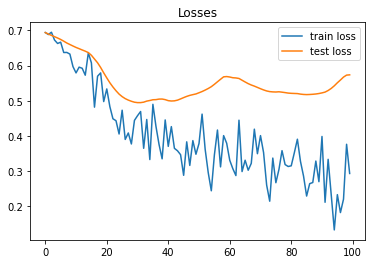

In [44]:
plt.plot([loss.to('cpu').detach().numpy() for loss in train_losses], label='train loss')
plt.plot([loss.to('cpu').detach().numpy() for loss in test_losses], label='test loss')
plt.title('Losses')
plt.legend()
plt.show()

### Predict and save submission

In [45]:
def test_tok(text):
    one_hot = np.zeros(len(vocab))
    one_hot[vocab(text)] = 1.0
    return torch.Tensor(one_hot)

df_test['tok_text'] = df_test['new_text'].apply(test_tok)

answer = []
with torch.no_grad():
    for i in df_test['tok_text'].values:
        i = i.to(device)
        y_test = model(i)
        answer.append(torch.max(y_test, 0)[1].item())

df_predict = pd.concat([df_test['id'], pd.DataFrame(answer, dtype='int', columns=['target'])], axis=1)

df_predict.to_csv('submission.csv', index=False)

# BEST and FASTEST - Logistic Regression

### Сonvert lists from 'new_text' into sentences

In [46]:
df_train['for_lr_model'] = df_train['new_text'].apply(list_to_str)
df_test['for_lr_model'] = df_test['new_text'].apply(list_to_str)

### Make a pipeline from TfidfVectorizer() and LogisticRegression()

In [47]:
text_lr = Pipeline([('tfidf', TfidfVectorizer()),
                     ('lr', LogisticRegression())
])

### Split the data and train the model

In [48]:
X = df_train['for_lr_model']
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

text_lr.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('lr', LogisticRegression())])

### Model score

In [49]:
prediction = text_lr.predict(X_test)
print(confusion_matrix(y_test, prediction))
print(accuracy_score(y_test, prediction))

[[1295  151]
 [ 344  723]]
0.8030242737763629


### Predict and save submission

In [50]:
predict = text_lr.predict(df_test['for_lr_model'])
df_predict = pd.concat([df_test['id'], pd.DataFrame(predict, dtype='int', columns=['target'])], axis=1)
df_predict.to_csv('submission.csv', index=False)